In [2]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns

sns.set_style("whitegrid")

In [5]:
def imbalance_predictiveness(
    df: pl.DataFrame,
    horizons: list[int] = list(range(1, 61)),
    thresholds: list[float] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    resample_ms: int = 1000,
) -> pl.DataFrame:
    """
    Compute E[sign(Imb) * (P_{t+h} - P_t) | |Imb| > threshold]

    Args:
      df: parquet with ts_event (ns), mid, imb
      horizons: list of horizon steps (in units of resample_ms)
      thresholds: |imb| thresholds to condition on
      resample_ms: resampling interval in milliseconds

    Returns:
      DataFrame with columns: threshold, horizon_s, mean, se, count
    """
    resample_ns = resample_ms * 1_000_000

    # resample to regular grid
    df_rs = (
        df.select("ts_event", "mid", "imbalance")
        .with_columns((pl.col("ts_event") // resample_ns).alias("ts_bin"))
        .group_by("ts_bin")
        .agg(pl.col("mid").last(), pl.col("imbalance").last())
        .sort("ts_bin")
    )

    # precompute sign and abs
    imb_sign = df_rs["imbalance"].sign()
    imb_abs = df_rs["imbalance"].abs()
    mid = df_rs["mid"]

    rows = []
    for thr in thresholds:
        mask = imb_abs > thr
        for h in horizons:
            sym_dp = (imb_sign * (mid.shift(-h) - mid)).filter(mask).drop_nulls()
            n = len(sym_dp)
            if n == 0:
                continue
            m = sym_dp.mean()
            s = sym_dp.std() / (n**0.5)
            rows.append((thr, h * resample_ms / 1000, m, s, n))

    return pl.DataFrame(
        rows,
        schema={
            "threshold": pl.Float64,
            "horizon_s": pl.Float64,
            "mean": pl.Float64,
            "se": pl.Float64,
            "count": pl.Int64,
        },
        orient="row",
    )

In [28]:
df1 = pl.read_parquet(
    "/home/labcmap/saad.souilmi/dev_cpp/qr/data/results/PFE/samples/7d9663e2.parquet"
)
result1 = imbalance_predictiveness(df1)
df2 = pl.read_parquet(
    "/home/labcmap/saad.souilmi/dev_cpp/qr/data/results/PFE/samples/7118edb7.parquet"
)
result2 = imbalance_predictiveness(df2)

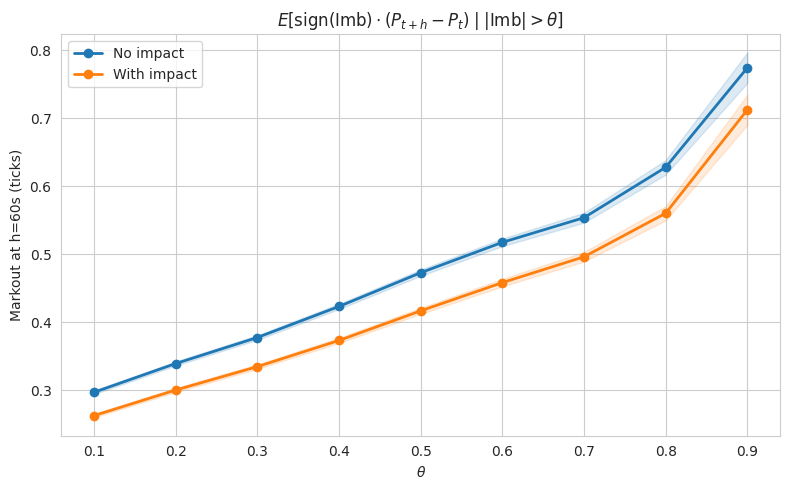

In [29]:
fig, ax = plt.subplots(figsize=(8, 5))

max_h = int(max(result1["horizon_s"]))

for result, label, color in [
    (result1, "No impact", "C0"),
    (result2, "With impact", "C1"),
]:
    thresholds = sorted(result["threshold"].unique().to_list())
    means = []
    ses = []
    for thr in thresholds:
        sub = result.filter(
            (pl.col("threshold") == thr) & (pl.col("horizon_s") == max_h)
        )
        means.append(sub["mean"][0])
        ses.append(sub["se"][0])
    means, ses = np.array(means), np.array(ses)
    ax.plot(thresholds, means, marker="o", color=color, lw=2, label=label)
    ax.fill_between(
        thresholds, means - 1.96 * ses, means + 1.96 * ses, color=color, alpha=0.15
    )

ax.set_xlabel(r"$\theta$")
ax.set_ylabel(f"Markout at h={max_h}s (ticks)")
ax.set_title(
    r"$E\left[\mathrm{sign}(\mathrm{Imb}) \cdot (P_{t+h}-P_t)\;\middle|\;|\mathrm{Imb}| >\theta\right]$"
)
ax.legend()
plt.tight_layout()
plt.show()

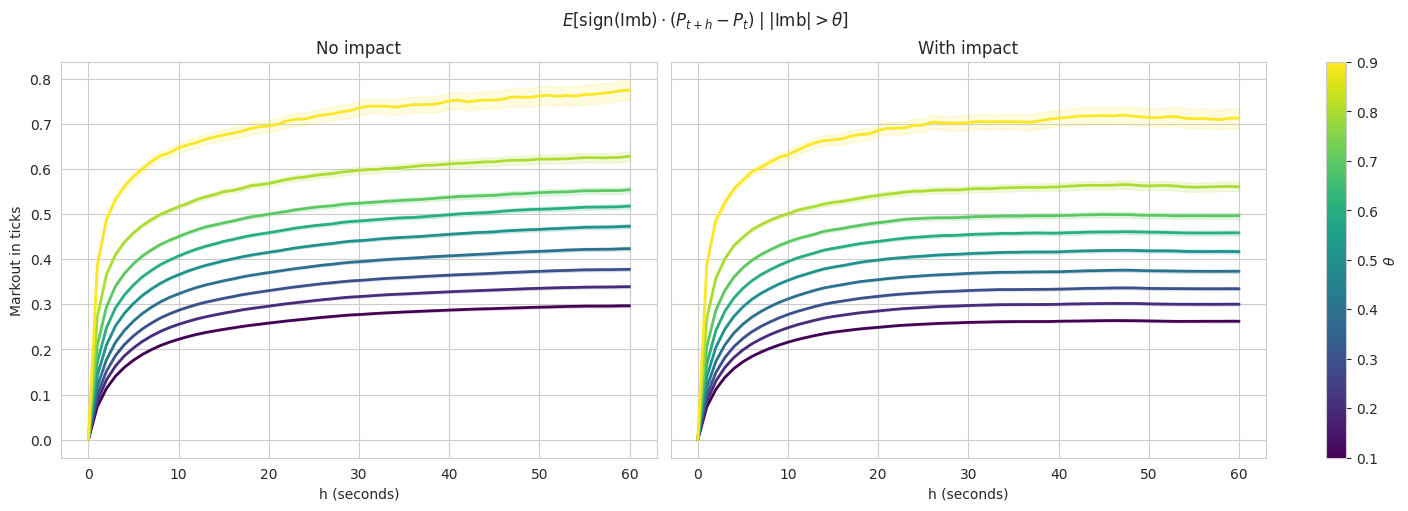

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharey=True, layout="constrained")

all_thresholds = sorted(result1["threshold"].unique().to_list())
norm = mcolors.Normalize(vmin=min(all_thresholds), vmax=max(all_thresholds))
cmap = plt.cm.viridis

for ax, result, title in [
    (ax1, result1, "No impact"),
    (ax2, result2, "With impact"),
]:
    thresholds = sorted(result["threshold"].unique().to_list())
    for thr in thresholds:
        sub = result.filter(pl.col("threshold") == thr).sort("horizon_s")
        h = np.concatenate([[0], sub["horizon_s"].to_numpy()])
        m = np.concatenate([[0], sub["mean"].to_numpy()])
        se = np.concatenate([[0], sub["se"].to_numpy()])
        color = cmap(norm(thr))
        ax.plot(h, m, color=color, lw=2)
        ax.fill_between(h, m - 1.96 * se, m + 1.96 * se, color=color, alpha=0.15)

    ax.set_xlabel("h (seconds)")
    ax.set_title(title)

ax1.set_ylabel("Markout in ticks")

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(sm, ax=[ax1, ax2], label=r"$\theta$")
plt.suptitle(
    r"$E\left[\mathrm{sign}(\mathrm{Imb}) \cdot (P_{t+h}-P_t)\;\middle|\;|\mathrm{Imb}| > \theta\right]$"
)
plt.show()